In [6]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC

## Прблемы вложенной кросс-валидации

Давайте сравним две кросс-валидации вложенную внутри оператора кросс-валидации и невложенную, например внутри решетчатого поиска, и понаблюдаем за некоторыми важными эффектами.  
Для сравниваются вложенной и не вложенной кросс-валидации для классификации используем набор данных Ирисы Фишера.  
Вложенная перекрестная проверка (CV) часто используется для обучения модели, в которой также необходимо подобрать  гиперпараметры. Вложенная CV оценивает ошибку обобщения базовой модели и качество подбора параметров.  
Выяснилось, что подбор параметров, которые максимизируют невложенную CV, допускает утечку данных, давая чрезмерно оптимистичную оценку.

При выборе модели без вложенных CV используются одни и те же данные для настройки параметров модели и оценки производительности модели. Таким образом, информация может “просачиваться” в модель и переопределять данные. Величина этого эффекта в первую очередь зависит от размера набора данных и стабильности модели. Анализ этих проблем приведен в работе [Коули и Тэлбота](https://jmlr.csail.mit.edu/papers/volume11/cawley10a/cawley10a.pdf).

Чтобы избежать этой проблемы, вложенную CV эффективно использует серию разбиений на обучающие/поверочные/тестовые наборы. Во внутреннем цикле (например выполняемом `GridSearchCV`) оценка приблизительно максимизируется путем подгонки модели к каждому обучающему набору, а затем непосредственно максимизируется при выборе (гиперпараметров) для набора проверки. Во внешнем цикле (например, в `cross_val_score`) ошибка обобщения оценивается путем усреднения результатов тестового набора по нескольким разделам набора данных.

В приведенном ниже примере используется классификатор машину опорных векторов с нелинейным ядром для построения модели с оптимизированными гиперпараметрами с помощью поиска по сетке. Затем сравниваем эффективность стратегий без вложения и с вложеннием CV, а также покажем разницу между их оценками.

Среднее 0.010289 со станндартным отклонением 0.008418.


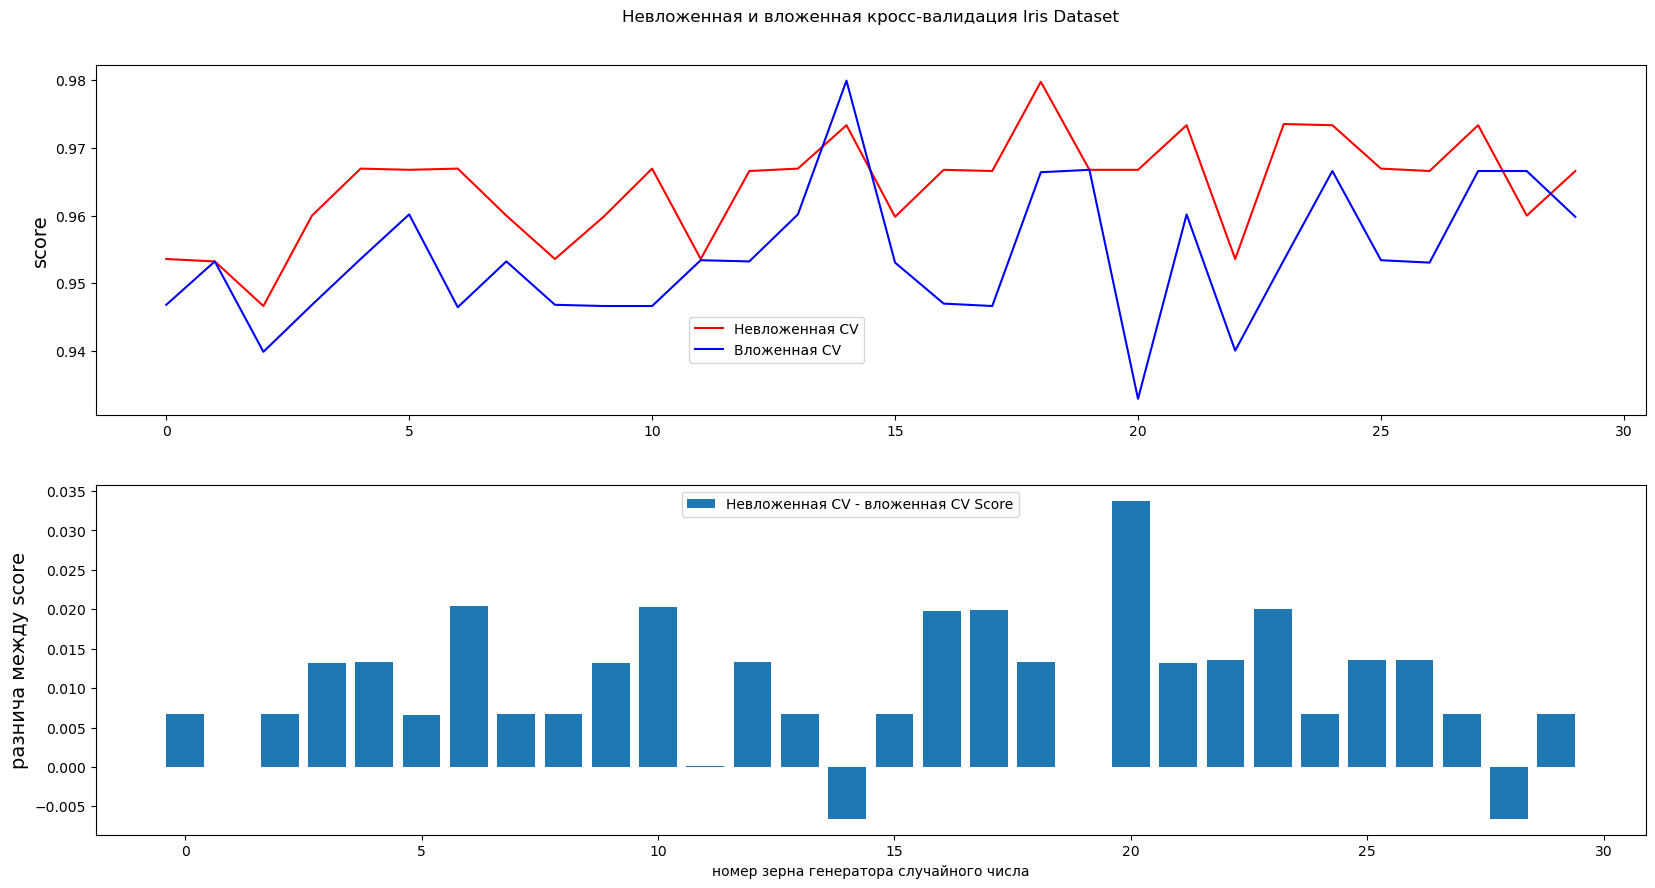

In [29]:
# Возьмем различные фиксироанные "зерна"
NUM_TRIALS = 30

#Грузим датасет
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Установим параметры для поиска оптимальных значений
p_grid = {"svc__C": [1, 10, 100], "svc__gamma": [0.01, 0.1]}

# возьмем rbf ядро в машину опорных векторов
svm = make_pipeline(StandardScaler(), SVC(kernel="rbf"))

# Списки для результатов
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Цикл для каждого "зерна"
for i in range(NUM_TRIALS):
    # Выбор методы перекрестной проверки для внутреннего и внешнего цикла
    # независимо от набора данных

    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Не вложенный CV параметров и скоринга 
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Вложенная CV с оптимизированными параметрами
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Среднее {:6f} со станндартным отклонением {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# График метрики для вложенной и невложенной CV
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
                        
(non_nested_scores_line,) = ax[0].plot(non_nested_scores, color="r")
(nested_line,) = ax[0].plot(nested_scores, color="b")
ax[0].set_ylabel("score", fontsize="14")
ax[0].legend(
    [non_nested_scores_line, nested_line],
    ["Невложенная CV", "Вложенная CV"],
    bbox_to_anchor=(0, 0.3, 0.5, 0),
)
ax[0].set_title(
    "Невложенная и вложенная кросс-валидация Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="12",
)

# Plot bar chart of the difference.
difference_plot = ax[1].bar(range(NUM_TRIALS), score_difference)
ax[1].set_xlabel("номер зерна генератора случайного числа")
ax[1].legend(
    [difference_plot],
    ["Невложенная CV - вложенная CV Score"],
    bbox_to_anchor=(0, 1, 0.6, 0),
)
ax[1].set_ylabel("разнича между score", fontsize="14")

plt.show()